Image from https://diode-dataset.org/

Computer Vision Model: https://universe.roboflow.com/microsoft/coco/model/37

Depth Model: https://depth-anything-v2.github.io/


In [10]:
# Install required libraries
!pip install onnxruntime opencv-python numpy matplotlib pillow inference supervision

In [11]:
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt
import torch
from PIL import Image
import time
import os
from pathlib import Path
from transformers import pipeline
from inference import get_model
import supervision as sv

[05/04/25 22:21:47] WARNING  Your inference package version 0.46.1 is out of date! Please upgrade to ]8;id=594741;file://c:\Users\Miguel\Miniconda3\Lib\site-packages\inference\core\__init__.py\__init__.py]8;;\:]8;id=925684;file://c:\Users\Miguel\Miniconda3\Lib\site-packages\inference\core\__init__.py#41\41]8;;\
                             version 0.48.1 of inference for the latest features and bug fixes by                  
                             running `pip install --upgrade inference`.                                            

ModelDependencyMissing: Your `inference` configuration does not support PaliGemma model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Florence2 model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support Qwen2.5-VL model. Use pip install 'inference[transformers]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[sam]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does not support SAM model. Use pip install 'inference[clip]' to install missing requirements.
ModelDependencyMissing: Your `inference` configuration does

In [12]:
pipe = pipeline(task="depth-estimation", model="depth-anything/Depth-Anything-V2-Small-hf")
image = Image.open("test1.jpg")
depth = pipe(image)["depth"]

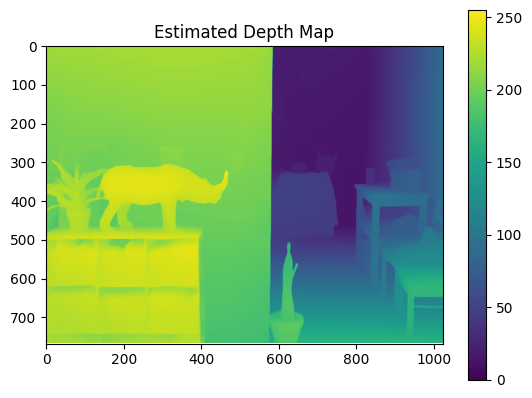

In [13]:
import matplotlib.pyplot as plt

# Display the depth map
plt.imshow(depth)
plt.title("Estimated Depth Map")
plt.colorbar() # Optional: adds a color bar to show depth scale
plt.show()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


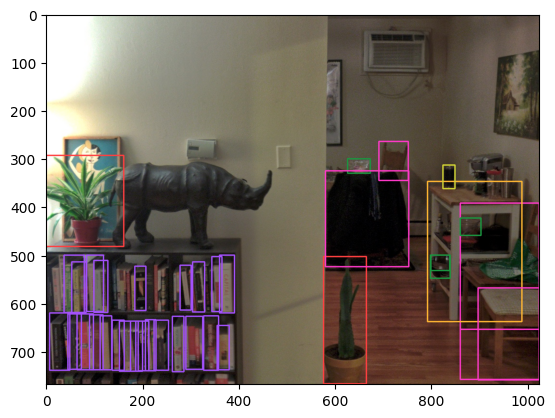

In [14]:
object_detection_model = get_model(
    model_id="coco/37", 
    api_key=""
)

# Load image
image_path = "test1.jpg"
frame = cv2.imread(image_path)

# will edit later
player_result = object_detection_model.infer(frame, confidence=0.3)[0]
player_detections = sv.Detections.from_inference(player_result)

# Annotate object with Bounding Boxes
box_annotator = sv.BoundingBoxAnnotator(thickness=2) # Use BoundingBoxAnnotator

# Annotate the original 'frame' with the detected boxes
# Store the result in 'annotated_frame_boxes'
annotated_frame_boxes = box_annotator.annotate(
    scene=frame.copy(), # Use frame.copy() to avoid modifying the original
    detections=player_detections
)

plt.imshow(cv2.cvtColor(annotated_frame_boxes, cv2.COLOR_BGR2RGB))
plt.show()



SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


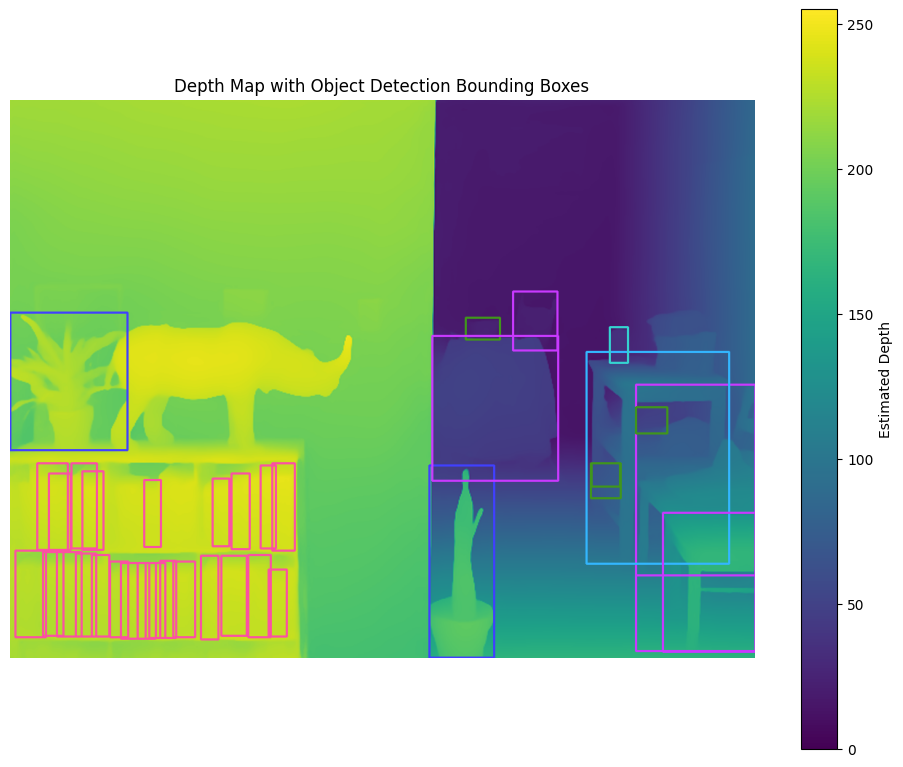

In [15]:
import matplotlib.cm as cm

depth_array = None
if isinstance(depth, Image.Image):
    depth_array = np.array(depth)
elif isinstance(depth, np.ndarray):
    depth_array = depth.copy()
else:
    raise TypeError(f"Error: 'depth' variable is of unexpected type: {type(depth)}. Cannot proceed.")

# Clean potential NaN/Inf values
if np.isnan(depth_array).any() or np.isinf(depth_array).any():
    print("Warning: NaN or Inf values found in depth map, replacing with 0.")
    # Replace NaN/Inf with 0 or another value like the median/mean if appropriate
    depth_array = np.nan_to_num(depth_array, nan=0.0, posinf=0.0, neginf=0.0)

# Issue with this calculation will fix
vmin = np.min(depth_array)
vmax = np.max(depth_array)
if vmax > vmin:
    norm_depth_array = (depth_array - vmin) / (vmax - vmin)
else:
    norm_depth_array = np.zeros_like(depth_array) 


colormap = cm.get_cmap('viridis')
colored_depth_rgba = colormap(norm_depth_array) 

# Convert to RGB uint8 format (range [0, 255])
colored_depth_rgb_uint8 = (colored_depth_rgba[:, :, :3] * 255).astype(np.uint8)

# Bounding Box Annotator
if 'player_detections' not in locals():
     raise NameError("Error: 'player_detections' not found. Run object detection first.")
else:
    box_annotator = sv.BoundingBoxAnnotator(thickness=2)
    # Annotate the colorized depth map
    annotated_depth_with_boxes = box_annotator.annotate(
        scene=colored_depth_rgb_uint8.copy(), # Annotate the colorized depth map
        detections=player_detections
    )


fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(annotated_depth_with_boxes)
ax.set_title("Depth Map with Object Detection Bounding Boxes")
ax.axis('off')

# Add a colorbar representing the original depth scale
# Use the vmin/vmax calculated before normalization
norm_for_colorbar = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm_for_colorbar)
sm.set_array([]) # Necessary for the colorbar
fig.colorbar(sm, ax=ax, label='Estimated Depth', shrink=0.8) # Adjust shrink as needed

plt.show()

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


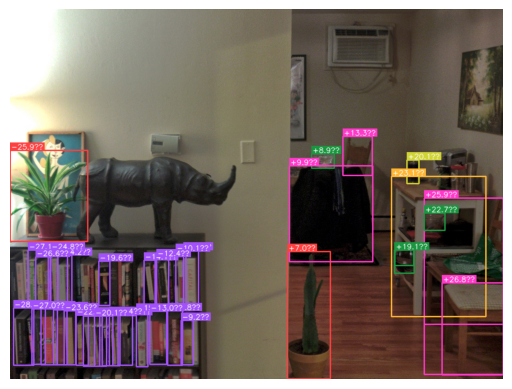

In [16]:
import math
import supervision as sv

# camera + angle stuff
FOV_H_DEG = 60
FOV_V_DEG = 45
H, W = frame.shape[:2]
cx, cy = W/2, H/2
fx = (W/2) / math.tan(math.radians(FOV_H_DEG/2))
fy = (H/2) / math.tan(math.radians(FOV_V_DEG/2))

angles, labels = [], []

for box in player_detections.xyxy:
    x1, y1, x2, y2 = box
    xc, yc = (x1+x2)/2, (y1+y2)/2
    theta_x = math.degrees(math.atan((xc - cx) / fx))
    theta_y = math.degrees(math.atan((yc - cy) / fy))
    angles.append((theta_x, theta_y))
    labels.append(f"{theta_x:+.1f}°")        # simple lateral label

# draw boxes
box_annotator = sv.BoundingBoxAnnotator(thickness=2)
annotated = box_annotator.annotate(scene=frame.copy(),
                                   detections=player_detections)

# add the angle labels
label_annotator = sv.LabelAnnotator(text_scale=0.5,
                                    text_thickness=1,
                                    text_padding=2)
annotated = label_annotator.annotate(scene=annotated,
                                     detections=player_detections,
                                     labels=labels)

plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [17]:
from transformers import AutoImageProcessor, ZoeDepthForDepthEstimation
import torch, numpy as np
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

# pick the joint model so you don't care whether the shot is indoor or outdoor
MODEL_ID = "Intel/zoedepth-nyu-kitti"

processor = AutoImageProcessor.from_pretrained(MODEL_ID)
model     = ZoeDepthForDepthEstimation.from_pretrained(MODEL_ID).to(device)

img  = Image.open("test1.jpg")
inputs = processor(images=img, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)

# post‑process back to the original resolution
depth_map = processor.post_process_depth_estimation(
                outputs, source_sizes=[(img.height, img.width)])[0]["predicted_depth"]

depth_m = depth_map.squeeze().cpu().numpy()      # depth in **metres**

# get metric distance of each detection
for box in player_detections.xyxy.astype(int):
    x1,y1,x2,y2 = box
    roi_depth   = depth_m[y1:y2, x1:x2]
    dist_m      = np.median(roi_depth)
    print(f"{dist_m:6.2f} m")


  2.26 m
  1.82 m
  5.45 m
  3.14 m
  2.76 m
  1.70 m
  1.66 m
  4.67 m
  1.70 m
  1.70 m
  3.31 m
  1.70 m
  1.70 m
  4.55 m
  1.70 m
  1.70 m
  1.69 m
  4.49 m
  1.67 m
  1.70 m
  1.70 m
  1.70 m
  1.66 m
  1.71 m
  1.70 m
  1.70 m
  1.70 m
  2.39 m
  1.68 m
  3.83 m
  3.79 m
  1.70 m
  1.70 m
  3.83 m
  1.70 m
  1.66 m
  1.71 m


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


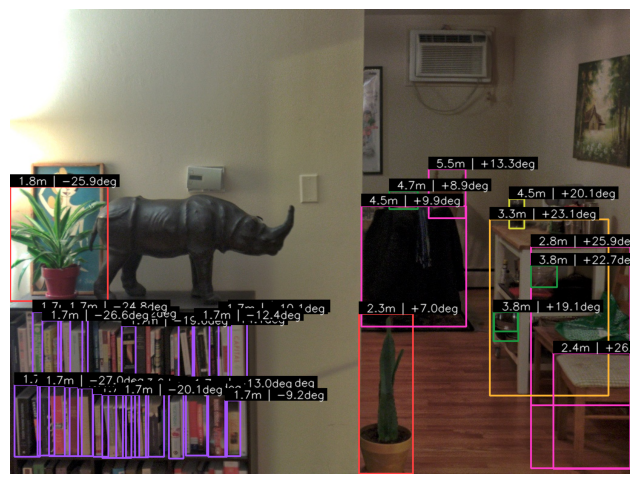

In [18]:
import numpy as np, math, supervision as sv, cv2, matplotlib.pyplot as plt

# build the text for every box
labels = []
distances = []

for i, box in enumerate(player_detections.xyxy.astype(int)):
    x1, y1, x2, y2 = box
    roi = depth_m[y1:y2, x1:x2]
    if roi.size < 9:         
        labels.append("")    # keep list lengths identical
        continue

    dist = np.median(roi)
    distances.append(dist)

    theta = angles[i][0]     # lateral angle we computed earlier
    labels.append(f"{dist:4.1f}m | {theta:+4.1f}deg")

# draw everything
box_annot = sv.BoundingBoxAnnotator(thickness=2)
img = box_annot.annotate(scene=frame.copy(), detections=player_detections)

label_annot = sv.LabelAnnotator(text_scale=0.6,
                                text_thickness=1,
                                text_padding=3,
                                text_color=sv.Color.WHITE,
                                color=sv.Color.BLACK)   # small black box behind text
img = label_annot.annotate(scene=img,
                           detections=player_detections,
                           labels=labels)

plt.figure(figsize=(8,8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [23]:
import time
import numpy as np
import cv2


try:
    import simpleaudio as sa
except ImportError:
    sa = None


class DepthCueEngine:
    """
    Turn a raw depth map into (a) an on‑screen overlay and
    (b) a minimal audio cue for blind‑navigation prototyping.
    """

    def __init__(
        self,
        near_thresh=1.5,       # metres
        mid_thresh=3.0,        # metres
        tone_map=(880, 660, 0),# Hz for Near / Mid / Far
        beep_length=0.08,      # seconds
        min_interval=0.25      # don’t beep faster than 4 Hz
    ):
        self.near = near_thresh
        self.mid = mid_thresh
        self.tone_map = tone_map
        self.beep_len = beep_length
        self.min_interval = min_interval
        self._last_beep = 0.0

    # udio#
    def _play_tone(self, freq_hz):
        """
        Non‑blocking sine beep.  Does nothing if simpleaudio is missing
        or if freq_hz == 0 (i.e. Far / safe).
        """
        if sa is None or freq_hz == 0:
            return

        fs = 44_100
        t = np.linspace(0, self.beep_len, int(fs * self.beep_len), False)
        wave = (np.sin(freq_hz * 2 * np.pi * t) * 32_767).astype(np.int16)
        sa.play_buffer(wave, 1, 2, fs)  # fire‑and‑forget


    def process(self, frame_bgr: np.ndarray, depth_m: np.ndarray):
        """
        -> overlay_frame, level (0/1/2), direction (0=L,1=C,2=R), min_depth
        """
        h, w = depth_m.shape
        thirds = np.array_split(depth_m, 3, axis=1)            # L | C | R
        medians = [np.nanmedian(t) for t in thirds]      # ignore NaNs
        dir_idx = int(np.argmin(medians))                # 0 / 1 / 2
        d_min = float(medians[dir_idx])


        if d_min < self.near:
            level = 0     # Near  -> red  -> high beep
        elif d_min < self.mid:
            level = 1     # Mid   -> yellow-> mid beep
        else:
            level = 2     # Far   -> green -> silent


        now = time.time()
        if now - self._last_beep > self.min_interval:
            self._play_tone(self.tone_map[level])
            self._last_beep = now


        # Normalise depth for a nice colour gradient
        depth_norm = cv2.normalize(
            depth_m, None, 0, 255, cv2.NORM_MINMAX
        ).astype(np.uint8)
        depth_color = cv2.applyColorMap(depth_norm, cv2.COLORMAP_MAGMA)

        overlay = cv2.addWeighted(frame_bgr, 0.35, depth_color, 0.65, 0)

        # Arrow from bottom‑centre to the “danger” direction
        x_tgt = int((dir_idx * 2 + 1) * w / 6)  
        y_tgt = int(h / 2)
        colour = (0, 0, 255) if level == 0 else (0, 255, 255) if level == 1 else (0, 255, 0)
        cv2.arrowedLine(
            overlay,
            (w // 2, h - 10),
            (x_tgt, y_tgt),
            colour,
            3,
            tipLength=0.18,
        )

        return overlay, level, dir_idx, d_min


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


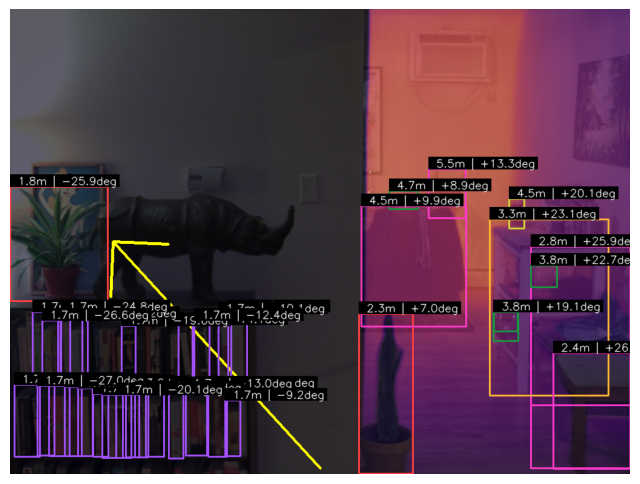

Global danger level: MID  | worst direction: LEFT  | min depth: 1.76 m


In [25]:
import numpy as np, cv2, supervision as sv
import matplotlib.pyplot as plt

labels = []
distances = []

for i, box in enumerate(player_detections.xyxy.astype(int)):
    x1, y1, x2, y2 = box
    roi = depth_m[y1:y2, x1:x2]
    if roi.size < 9:                 
        labels.append("")
        continue

    dist = np.median(roi)
    distances.append(dist)

    theta = angles[i][0]             
    labels.append(f"{dist:4.1f}m | {theta:+4.1f}deg")


cue = DepthCueEngine()               
overlay, lvl, dir_, d_min = cue.process(frame, depth_m)


box_annot   = sv.BoundingBoxAnnotator(thickness=2)
label_annot = sv.LabelAnnotator(text_scale=0.6,
                                text_thickness=1,
                                text_padding=3,
                                text_color=sv.Color.WHITE,
                                color=sv.Color.BLACK)

img = box_annot.annotate(scene=overlay, detections=player_detections)
img = label_annot.annotate(scene=img,
                           detections=player_detections,
                           labels=labels)


cv2.imshow("Assist‑Overlay", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

print(f"Global danger level: {['NEAR','MID','FAR'][lvl]}  "
      f"| worst direction: {['LEFT','CENTRE','RIGHT'][dir_]}  "
      f"| min depth: {d_min:.2f} m")
